<a href="https://www.kaggle.com/code/zrosen3/titanicsubmissionrosen?scriptVersionId=95163767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Below, I input the training and test data and take a first look at the data.

In [1]:
##data processing
#load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#load in training data
train = pd.read_csv("/kaggle/input/titanic/train.csv")
#load in test data
test = pd.read_csv("/kaggle/input/titanic/test.csv")
#list of training and test data
combined_data = pd.concat([train, test]).reset_index(drop = True) 

Looking at the type of each variable

In [2]:
combined_data.dtypes


PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Creat boxplots of numeric values

<AxesSubplot:xlabel='Age'>

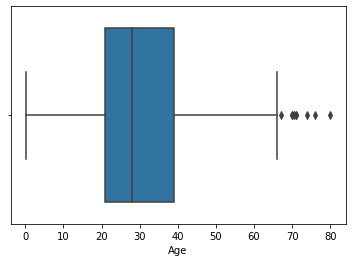

In [3]:
import seaborn as sns
sns.boxplot(x= combined_data['Age'])


<AxesSubplot:xlabel='Fare'>

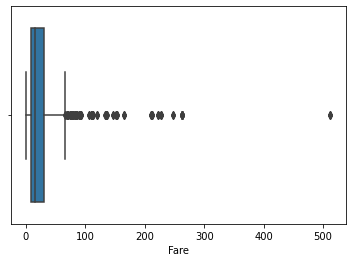

In [4]:
sns.boxplot(x= combined_data['Fare'])

<AxesSubplot:xlabel='SibSp'>

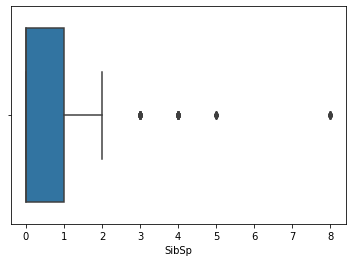

In [5]:
sns.boxplot(x= combined_data['SibSp'])

<AxesSubplot:xlabel='Parch'>

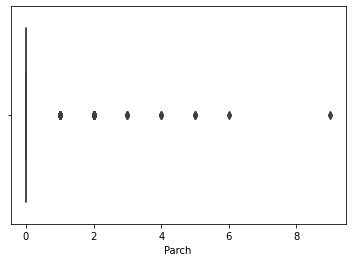

In [6]:
sns.boxplot(x= combined_data['Parch'])

Get summary statistics and missing values for all columns.

In [7]:
combined_data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


Look at how many null values in each column.

In [8]:
combined_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Age and cabin have a lot of missing values. Cabin is mostly missing values. 

Embarked has only a few missing values, so replace with most common value S.

In [9]:
combined_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [10]:
combined_data['Embarked'] =combined_data['Embarked'].fillna('S')

Create variable for family size, title, and is alone

In [11]:

#create variable for title, lsat name
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
combined_data['Family_Name'] = combined_data['Name'].str.split(', ', expand=True)[0]
combined_data['Temp'] = combined_data['Name'].str.split(', ', expand=True)[1]
combined_data['Title'] = combined_data['Temp'].str.split('.', expand = True)[0]
combined_data['Title'] = combined_data['Title'].replace('Mlle', 'Miss')
combined_data['Title'] = combined_data['Title'].replace('Ms', 'Miss')
combined_data['Title'] = combined_data['Title'].replace('Mme', 'Mrs')
combined_data.loc[~combined_data['Title'].isin(common_titles), "Title"] = "Other"


In [12]:
combined_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
Family_Name       0
Temp              0
Title             0
dtype: int64

In [13]:
combined_data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Other      29
Name: Title, dtype: int64

Look to see if cabin being non missing has some correlation to survived.

In [14]:
combined_data['CabinMissing'] = 0
combined_data.loc[combined_data['Cabin'].isnull(), 'CabinMissing'] = 1
combined_data.groupby(['CabinMissing'], as_index = False)['Survived'].mean()

,CabinMissing,Survived
0,0,0.666667
1,1,0.299854


Whether cabin or not is missing seems to be related to survival. Cabin data contains information on decks. See if deck related to survival

In [15]:
combined_data["Deck"] = combined_data["Cabin"].str.slice(stop=1)
combined_data["Deck"]= combined_data["Deck"].replace(np.nan, "Missing")
combined_data.groupby(['Deck'], as_index = False)['Survived'].mean()

,Deck,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,Missing,0.299854
8,T,0.000000


Creat variable for family size from siblings and parents

In [16]:
#create variable for family size
combined_data["FamilySize"] = combined_data["SibSp"] + combined_data["Parch"]
combined_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='FamilySize', ascending=False)


,FamilySize,Survived
8,10,0.000000
7,7,0.000000
6,6,0.333333
5,5,0.136364
4,4,0.200000
3,3,0.724138
2,2,0.578431
1,1,0.552795
0,0,0.303538


Meaningful variation seems to be found from grouping family size into groups 0, 1-3, and 4-10. However, very few observations in groups 4-10, so low survival rates may be noise. Just split into family sizes zero and non-zero.

In [17]:
combined_data['Alone'] = 0
combined_data.loc[combined_data['FamilySize'] == 0,'Alone'] = 1
combined_data[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean().sort_values(by='Alone', ascending=False)

,Alone,Survived
1,1,0.303538
0,0,0.505650


Split into training and test datasets

In [18]:
train_data = combined_data.iloc[:len(train)].copy()
test_data = combined_data.iloc[len(train):].copy()

Use linear regression to predict missing values for fare. 

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

#replace 0s with missings
train_data['Fare'] = train_data['Fare'].replace(0, np.nan)
test_data['Fare'] = test_data["Fare"].replace(0, np.nan)

#find missing rows in dataframe
non_missing_fares = train_data[train_data["Fare"].notnull()]
missing_train_fares = train_data[train_data["Fare"].isnull()]
missing_test_fares = test_data[test_data["Fare"].isnull()]
missing_fares = pd.concat([missing_train_fares, missing_test_fares])

#initialize model
features = ["Pclass", "Sex", "FamilySize"]
model = LinearRegression()
X = pd.get_dummies(non_missing_fares[features])
X_test = pd.get_dummies(missing_fares[features])
X_test["Sex_female"] = 0
y = non_missing_fares['Fare'].astype("int")
model.fit(X, y) 

#run model, look at performance
predictions = model.predict(X_test)
r_sq = model.score(X,y)
intercept = model.intercept_
coeffs = model.coef_
print("R squared:" + str(r_sq))
print("Intercepts:" + str(intercept) )
print("Coeffcients:" + str(coeffs))

R squared:0.3800848033415304
Intercepts:105.25184379899277
Coeffcients:[-34.09609364   7.32971009   2.58259515  -2.58259515]


In [20]:
missing_fares["Predicted_Fare"] = predictions
missing_fares = missing_fares[["Pclass", "Sex", "FamilySize", "Predicted_Fare"]].drop_duplicates()
train_data = train_data.merge(missing_fares, how = "left", on = ['Pclass', 'Sex', 'FamilySize'])
train_data['Fare'] = train_data['Fare'].fillna(train_data["Predicted_Fare"])
test_data = test_data.merge(missing_fares, how = "left", on = ['Pclass', 'Sex', 'FamilySize'])
test_data['Fare'] = test_data['Fare'].fillna(test_data["Predicted_Fare"])

Look if age is correlated with Pclass and sex

In [21]:
train_data.groupby(['Pclass'])['Age'].mean()


Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Look at distribution of age for pclass and sex groups.

In [22]:
train_data.groupby(['Sex', 'Pclass'])['Age'].mean()


Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

Predict missing values for age by mean of pclass and sex groups. Use mean since age is normally distributed.

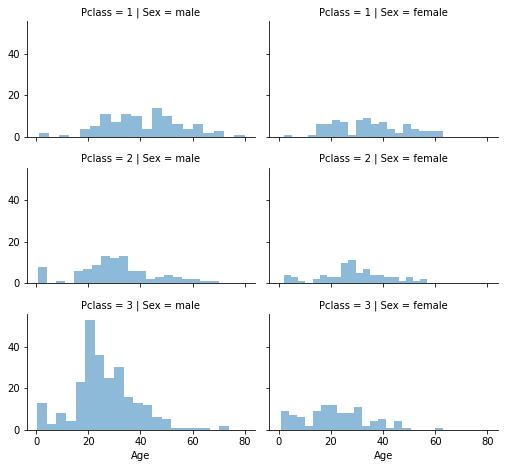

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
grid = sns.FacetGrid(train_data, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Impute missing age values using linear regression.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


#find missing rows in dataframe
non_missing_ages = train_data[train_data["Age"].notnull()]
missing_train = train_data[train_data["Age"].isnull()]
missing_test = test_data[test_data["Age"].isnull()]
missing_ages = pd.concat([missing_train, missing_test])

#initialize model
features = ["Pclass", "Sex", "FamilySize"]
model = LinearRegression()
X = pd.get_dummies(non_missing_ages[features])
X_test = pd.get_dummies(missing_ages[features])
y = non_missing_ages['Age'].astype("int")
model.fit(X, y) 

#run model, look at performance
predictions = model.predict(X_test)
r_sq = model.score(X,y)
intercept = model.intercept_
coeffs = model.coef_
print("R squared:" + str(r_sq))
print("Intercepts:" + str(intercept) )
print("Coeffcients:" + str(coeffs))

R squared:0.22419311101772643
Intercepts:46.0359610645211
Coeffcients:[-6.40857033 -2.55583777 -1.45023577  1.45023577]


Add predicted age value onto each dataset

In [25]:
missing_ages["Predicted_Age"] = predictions
missing_ages = missing_ages[["Pclass", "Sex", "FamilySize", "Predicted_Age"]].drop_duplicates()
train_data = train_data.merge(missing_ages, how = "left", on = ['Pclass', 'Sex', 'FamilySize'])
train_data['Age'] = train_data['Age'].fillna(train_data["Predicted_Age"])
test_data = test_data.merge(missing_ages, how = "left", on = ['Pclass', 'Sex', 'FamilySize'])
test_data['Age'] = test_data['Age'].fillna(test_data["Predicted_Age"])

Create family survival rate variable

In [26]:
#baseline survival rate is actual titanic survival rate
baseline = (2224-1502)/2224
#calculate family survival rate for train data, only count family sizes not 0
train_data["Family_Survival"] = train_data.groupby("Family_Name")["Survived"].transform('mean')
train_data.loc[train_data["Alone"] == 1, "Family_Survival"] = baseline
#calculate family survival rate for test data
family_rates_grouped = train_data.groupby("Family_Name")["Survived"].mean().rename("Family_Survival")
test_data = test_data.merge(family_rates_grouped, on = "Family_Name", how = "left")
#fill missing values with baseline
test_data["Family_Survival"] = test_data["Family_Survival"].fillna(baseline)
train_data["Family_Survival"] = train_data["Family_Survival"].fillna(baseline)


Select relevant features for modeling

In [27]:
features= ["Pclass", "Sex","Age", "Fare", "Title", "Embarked", "Deck","Alone", "Survived"]
train_data = train_data[features]
features.remove("Survived")
test_data = test_data[features]

Make sure that there are no remaining missing values.

In [28]:
print(train_data.isnull().sum())
print ("\n")
print(test_data[features].isnull().sum())


Pclass      0
Sex         0
Age         0
Fare        0
Title       0
Embarked    0
Deck        0
Alone       0
Survived    0
dtype: int64


Pclass      0
Sex         0
Age         0
Fare        0
Title       0
Embarked    0
Deck        0
Alone       0
dtype: int64


Create correlation matrix of different variables

<AxesSubplot:>

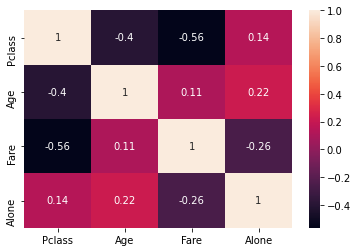

In [29]:
corrMatrix = train_data[features].corr()
sns.heatmap(corrMatrix, annot=True)


Extract dummy variables for random forest model.

In [30]:
y = train_data["Survived"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features]) 
X_test["Deck_T"] = 0

Run logistic regression to understand effects of different variables

In [31]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X, y)
predictions = logreg.predict(X_test).astype(int)
#look at score
log_score = round(logreg.score(X, y) * 100, 2)
log_score

82.6

Look at coefficients from logistic regression model

In [32]:
coefficients  = pd.DataFrame(X.columns.delete(0))
coefficients.columns = ['Feature']
coefficients["Correlation"] = pd.Series(logreg.coef_[0])
coefficients.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
6,Title_Miss,1.235193
4,Sex_male,0.953277
18,Deck_F,0.787778
9,Title_Other,0.655652
3,Sex_female,0.647335
17,Deck_E,0.550479
11,Embarked_Q,0.280794
19,Deck_G,0.264568
15,Deck_C,0.115394
12,Embarked_S,0.100314


Run grid search to tune hyperparameters

In [33]:
#function to return best score, best parameters for hyparameters tuning
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))
from sklearn.model_selection import GridSearchCV
#run grid search
#rf = RandomForestClassifier(random_state=123)

#param_grid = {'max_depth': [5, 10, 50],
            #  'criterion':['gini', 'entropy'],
             # 'n_estimators': [100, 200, 500, 1000],
              #'min_samples_split': [2,4,6]}

#grid_search_model = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = 0, n_jobs = -1)
#best_rf_model= grid_search_model.fit(X, y)
#clf_performance(best_rf_model,'Random Forest')

Run best random forest model based on grid search

In [34]:
##model
model = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 100)
model.fit(X, y)                                                                                                                                                           
predictions = model.predict(X_test).astype(int)

Look at decision tree score on training data

In [35]:
training_score = round(model.score(X,y) * 100, 2)
training_score

84.74

Run cross validation test for random forest model.

In [36]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(model,X, y,cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.82022472 0.82022472 0.7752809  0.84269663]
0.8181658401858012



Create output file and submit

In [37]:
##submission
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
